<a href="https://colab.research.google.com/github/lenasarien/Artrade-base-smart-contract/blob/main/NLP_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analyse + Deep Learn - Amazon App

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
! pip install google-play-scraper
from google_play_scraper import Sort, reviews_all, app, reviews
! pip install app-store-scraper
from app_store_scraper import AppStore
! pip install langdetect
from langdetect import detect
import random


In [ ]:
import re
!pip install unidecode
import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

## 1- Introduction

De nombreuses informations textuelles sont disponibles sur le Web pour comprendre le sentiment des utilisateurs concernant des sites Web, produits ou marques via des tweets et des avis. Lire chaque avis est impossible sans une éternité, mais former un ordinateur à le faire est une solution efficace.

Ce projet vise à créer un modèle d'apprentissage profond pour analyser et classer automatiquement les sentiments des utilisateurs en positifs, neutres et négatifs et ensuite générer des recommandations issues de cette apprentissage, pour aider à l'amélioration de la satisfaction client.




## 2- Les données

Dans ce projet, nous utiliserons les avis en français sur l'application Amazon Shopping, extraits de l'Apple Store et du Playstore à l'aide de Google_Play_Scraper et de l'API App_Store_Scraper. Les données fusionnées forment un DataFrame avec deux colonnes : « Avis » (str) et « Scores » (int), où les notes varient de 1 à 5.

## 3- Méthodologie

Pour identifier le meilleur modèle de classification de texte multi-étiquettes, nous commencerons par prétraiter notre texte via un pipeline incluant les expressions régulières, la suppression des mots vides et la lemmatisation. Ensuite, nous analyserons nos données en traçant les N-grams courants, la distribution des sentiments et un nuage de mots pour chaque sentiment. Avant la modélisation, nous diviserons les données en ensembles de test et d'entraînement, vectoriserons, équilibrerons l'ensemble, et créerons des fonctions pour l'évaluation du modèle. Nous construirons un réseau neuronal pour la classification multi-étiquettes, suivi d'une fonction qui appliquera ce modèle et affichera les prédictions et pourcentages pour chaque avis ajouté.

## 4- Extraction de données

## 4.1 - Web Scrapping

In [2]:
# Liste des pays par code
countries = {
    "Afrique du Sud": "za",
    "Nigéria": "ng",
    "Égypte": "eg",
    "Inde": "in",
    "Chine": "cn",
    "Japon": "jp",
    "France": "fr",
    "Allemagne": "de",
    "Royaume-Uni": "gb",
    "États-Unis": "us",
    "Canada": "ca",
    "Mexique": "mx",
    "Brésil": "br",
    "Argentine": "ar",
    "Colombie": "co",
    "Australie": "au",
    "Nouvelle-Zélande": "nz"
}

# Liste pour stocker les résultats
all_reviews = []

# Identifiant de l'application Amazon Shopping
app_package_name = 'com.amazon.mShop.android.shopping'

# Récupération des avis pour chaque pays
for country_name, country_code in countries.items():
    num_reviews = random.randint(200, 5000)  # Nombre aléatoire d'avis entre 100 et 2000
    reviews_result, continuation_token = reviews(
        app_package_name,
        lang='fr',  # Langue française (ou changez pour 'en' si nécessaire)
        country=country_code,  # Code du pays
        count=num_reviews,  # Nombre d'avis à récupérer
        filter_score_with=None  # Aucun filtre de score
    )

    # Stockage des avis avec l'indication du pays
    for review in reviews_result:
        review_data = {
            'score': review['score'],
            'review': review['content'],
            'date': review['at'],
            'country': country_name
        }
        all_reviews.append(review_data)

# Création d'un DataFrame
df_reviews = pd.DataFrame(all_reviews)

# Affichage des premiers résultats
df_reviews.head()

,score,review,date,country
0,5,toujours aussi réactive avec des livraisons au...,2024-07-29 14:06:53,Afrique du Sud
1,3,Kaka Frédéric,2024-07-29 09:39:16,Afrique du Sud
2,5,L'appli ne fonctionne plus depuis un moment es...,2024-07-29 09:09:42,Afrique du Sud
3,1,J'espère que cette application est GRATUITE ca...,2024-07-29 08:36:34,Afrique du Sud
4,1,Impossible de se connecter au Locker et donc d...,2024-07-29 08:13:34,Afrique du Sud


In [3]:
df_reviews.shape

(39370, 4)

In [4]:
# Liste des pays francophones par code
francophone_countries = {
    "France": "fr",
    "Belgique": "be",
    "Suisse": "ch",
    "Côte d'Ivoire": "ci",
    "Sénégal": "sn",
    "Mali": "ml",
    "Cameroun": "cm",
    "Maroc": "ma",
    "Algérie": "dz",
    "Tunisie": "tn",
    "Canada": "ca",
    "Haïti": "ht",
    "Nouvelle-Calédonie": "nc",
    "Liban": "lb"
}

# Fonction pour récupérer les avis d'un pays spécifique
def get_reviews_from_country(app_name, country_name, country_code):
    app = AppStore(country=country_code, app_name=app_name)
    app.review(how_many= random.randint(200, 10000))

    reviews = []
    for review in app.reviews:
        # Détection de la langue de l'avis
        try:
            if detect(review['review']) == 'fr':
                review_data = {
                    'score': review['rating'],
                    'review': review['review'],
                    'date': review['date'],
                    'country': country_name
                }
                reviews.append(review_data)
        except:
            # Ignorer les erreurs de détection de langue
            continue

    return reviews

# Collecte des avis pour chaque pays francophone
all_reviews_app_store = []
app_name = "amazon-shopping"  # Identifiant de l'application sur l'App Store

for country_name, country_code in francophone_countries.items():
    reviews = get_reviews_from_country(app_name, country_name, country_code)
    all_reviews_app_store.extend(reviews)

# Création d'un DataFrame pour les avis de l'App Store
df_reviews_app_store = pd.DataFrame(all_reviews_app_store)

# Affichage des premiers résultats
df_reviews_app_store.head()

ERROR:Base:Something went wrong: HTTPSConnectionPool(host='amp-api.apps.apple.com', port=443): Max retries exceeded with url: /v1/catalog/fr/apps/297606951/reviews?l=en-GB&offset=0&limit=20&platform=web&additionalPlatforms=appletv%2Cipad%2Ciphone%2Cmac (Caused by ResponseError('too many 429 error responses'))
ERROR:Base:Something went wrong: HTTPSConnectionPool(host='amp-api.apps.apple.com', port=443): Max retries exceeded with url: /v1/catalog/be/apps/297606951/reviews?l=en-GB&offset=0&limit=20&platform=web&additionalPlatforms=appletv%2Cipad%2Ciphone%2Cmac (Caused by ResponseError('too many 429 error responses'))
ERROR:Base:Something went wrong: HTTPSConnectionPool(host='amp-api.apps.apple.com', port=443): Max retries exceeded with url: /v1/catalog/ch/apps/297606951/reviews?l=en-GB&offset=0&limit=20&platform=web&additionalPlatforms=appletv%2Cipad%2Ciphone%2Cmac (Caused by ResponseError('too many 429 error responses'))
ERROR:Base:Something went wrong: HTTPSConnectionPool(host='amp-api.

""


In [5]:
df_reviews_app_store.shape


(0, 0)

In [6]:
# Fusion des DataFrames
amazon_reviews = pd.concat([df_reviews, df_reviews_app_store], ignore_index=True)

# Affichage des résultats fusionnés
amazon_reviews.head()


,score,review,date,country
0,5,toujours aussi réactive avec des livraisons au...,2024-07-29 14:06:53,Afrique du Sud
1,3,Kaka Frédéric,2024-07-29 09:39:16,Afrique du Sud
2,5,L'appli ne fonctionne plus depuis un moment es...,2024-07-29 09:09:42,Afrique du Sud
3,1,J'espère que cette application est GRATUITE ca...,2024-07-29 08:36:34,Afrique du Sud
4,1,Impossible de se connecter au Locker et donc d...,2024-07-29 08:13:34,Afrique du Sud


In [7]:
# Vérification des doublons
print(amazon_reviews.duplicated().sum())

0


In [8]:
# Vérification des valeurs manquantes
print(amazon_reviews.isnull().sum())

score      0
review     0
date       0
country    0
dtype: int64


In [9]:
# Enregistrement du DataFrame au format CSV
amazon_reviews.to_csv('amazon_reviews.csv', index=False)


## 4.2 - Vérification des données

In [10]:
amazon_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39370 entries, 0 to 39369
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   score    39370 non-null  int64         
 1   review   39370 non-null  object        
 2   date     39370 non-null  datetime64[ns]
 3   country  39370 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.2+ MB


In [11]:
amazon_reviews['score'].value_counts()

score
5    15068
1    15052
4     3518
3     2887
2     2845
Name: count, dtype: int64

In [12]:
amazon_reviews['country'].value_counts()

country
Afrique du Sud      4710
Argentine           3692
États-Unis          3607
Canada              3139
Chine               3044
Nouvelle-Zélande    2911
Inde                2344
Nigéria             2317
Allemagne           2190
Mexique             2177
Japon               2042
Royaume-Uni         1728
Colombie            1710
France              1516
Australie            770
Brésil               744
Égypte               729
Name: count, dtype: int64

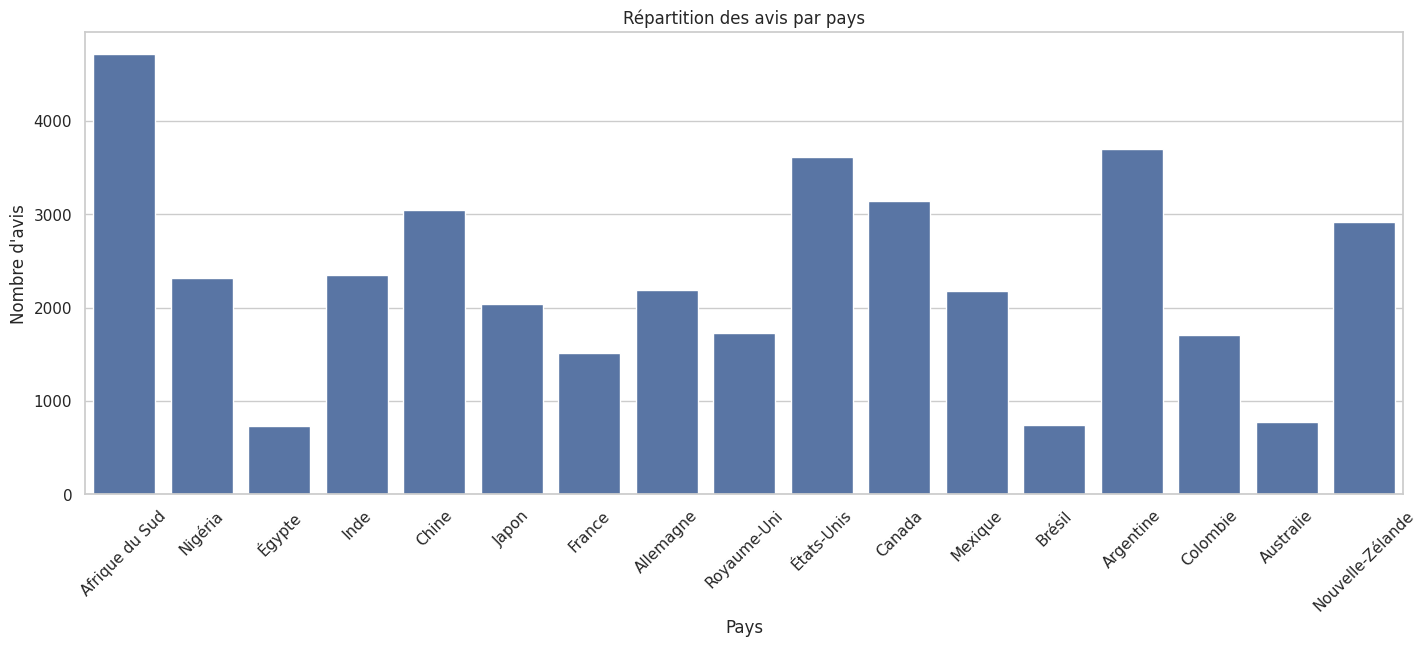

In [13]:
# Visualisation de la répartition des classes
sns.set(style="whitegrid")
plt.figure(figsize=(17, 6))
sns.countplot(x='country', data=amazon_reviews)
plt.title('Répartition des avis par pays')
plt.xlabel('Pays')
plt.ylabel("Nombre d'avis")
plt.xticks(rotation=45)
plt.show()

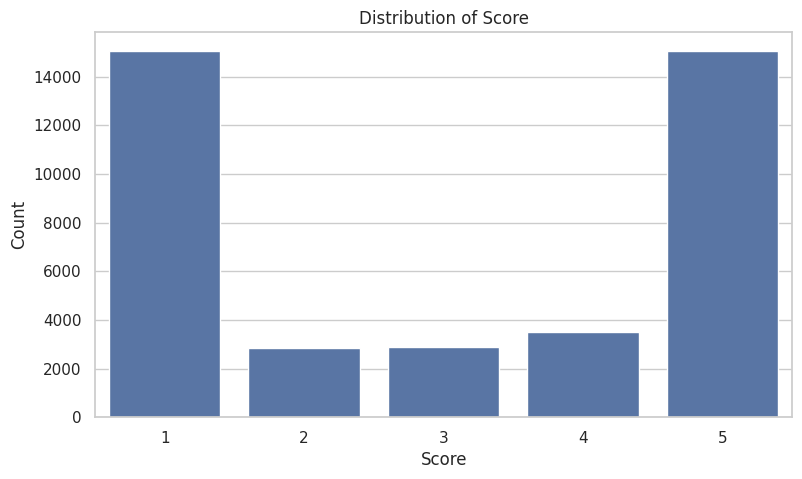

In [14]:
# Visualisation de la repartition par score
sns.set(style="whitegrid")
plt.figure(figsize=(9, 5))
sns.countplot(data=amazon_reviews, x='score')
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [15]:
def Sentiment_analysis(score):

    # Classifying based on Score
    if score > 3 :
        return 'Positive'
    elif score < 3 :
        return 'Negative'
    else:
        return 'Neutral'

# Applying TextBlob sentiment analysis to the reviews
amazon_reviews['sentiment'] = amazon_reviews['score'].apply(Sentiment_analysis)

amazon_reviews.head(20)

,score,review,date,country,sentiment
0,5,toujours aussi réactive avec des livraisons au...,2024-07-29 14:06:53,Afrique du Sud,Positive
1,3,Kaka Frédéric,2024-07-29 09:39:16,Afrique du Sud,Neutral
2,5,L'appli ne fonctionne plus depuis un moment es...,2024-07-29 09:09:42,Afrique du Sud,Positive
3,1,J'espère que cette application est GRATUITE ca...,2024-07-29 08:36:34,Afrique du Sud,Negative
4,1,Impossible de se connecter au Locker et donc d...,2024-07-29 08:13:34,Afrique du Sud,Negative
5,5,rapide précise parfaite,2024-07-29 08:07:53,Afrique du Sud,Positive
6,4,C'est cool'os !!,2024-07-29 01:23:02,Afrique du Sud,Positive
7,3,C'est bien et pratique car c'est rapide parcon...,2024-07-28 17:25:47,Afrique du Sud,Neutral
8,5,Très content d amazon ils y a tous pas besoin ...,2024-07-28 15:51:27,Afrique du Sud,Positive
9,1,Pénible. obligé d'utiliser l'app pour retirer ...,2024-07-28 14:04:15,Afrique du Sud,Negative


In [16]:
# Agréger les données par pays et par score
pivot_data = amazon_reviews.pivot_table(index='country', columns='score', values='review', aggfunc='count', fill_value=0)

# Réorganiser les colonnes pour avoir les scores de 1 à 5
pivot_data = pivot_data.sort_index(axis=1)

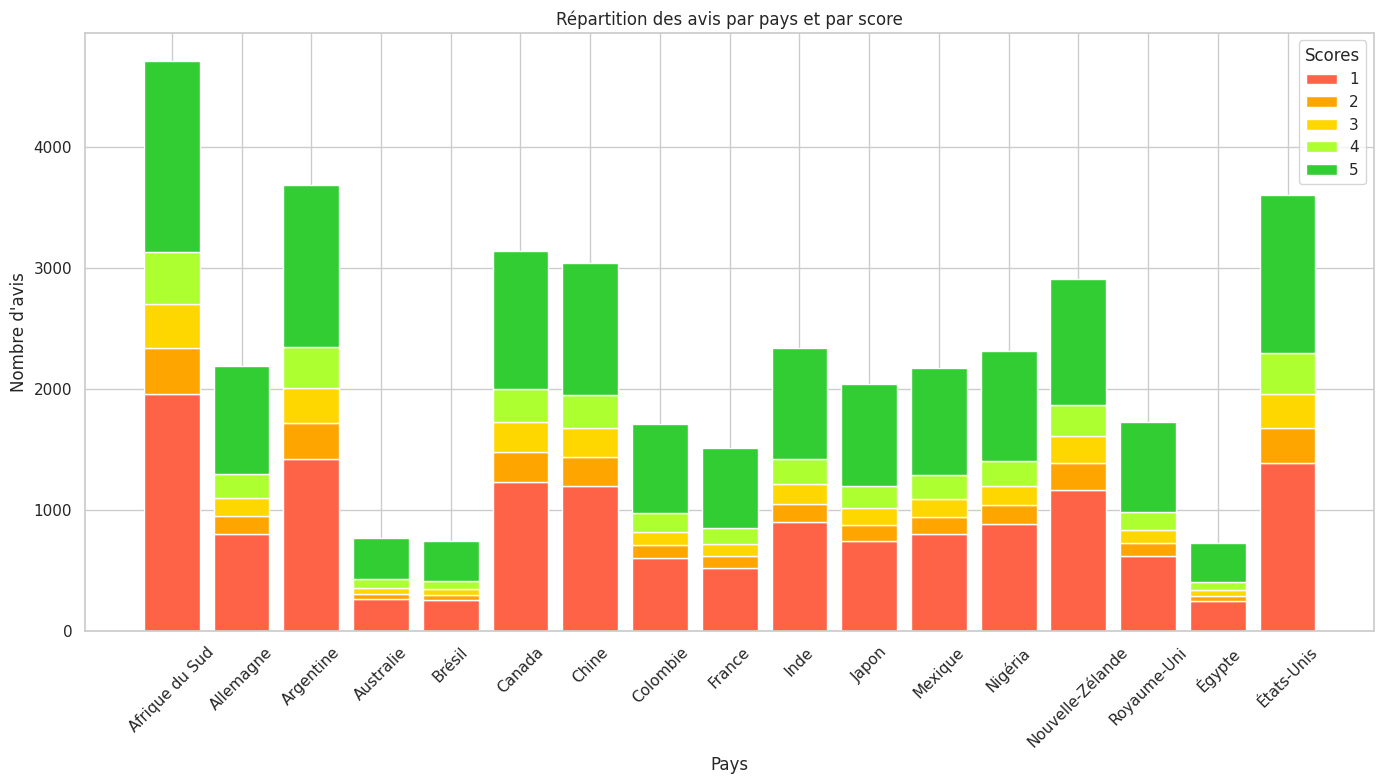

In [17]:
# Préparation des données pour le graphique
pays = pivot_data.index
scores = pivot_data.columns
colors = ['#FF6347', '#FFA500', '#FFD700', '#ADFF2F', '#32CD32']  # Couleurs pour chaque score

# Création des barres empilées
bottoms = np.zeros(len(pays))  # Initialise le bas de chaque barre à 0

plt.figure(figsize=(14, 8))

for i, score in enumerate(scores):
    plt.bar(pays, pivot_data[score], bottom=bottoms, color=colors[i], label=f'{score}')
    bottoms += pivot_data[score]  # Met à jour le bas pour le prochain empilement

# Configuration du graphique
plt.xlabel('Pays')
plt.ylabel('Nombre d\'avis')
plt.title('Répartition des avis par pays et par score')
plt.legend(title='Scores')
plt.xticks(rotation=45)  # Rotation des labels des pays pour une meilleure lisibilité

# Affichage du graphique
plt.tight_layout()
plt.show()

In [18]:
df = amazon_reviews.drop(['date', 'score'], axis=1)
df.head()

,review,country,sentiment
0,toujours aussi réactive avec des livraisons au...,Afrique du Sud,Positive
1,Kaka Frédéric,Afrique du Sud,Neutral
2,L'appli ne fonctionne plus depuis un moment es...,Afrique du Sud,Positive
3,J'espère que cette application est GRATUITE ca...,Afrique du Sud,Negative
4,Impossible de se connecter au Locker et donc d...,Afrique du Sud,Negative


# 5 - Traitement de texte

Pour la validation future de notre modèle, nous allons créer un pipeline de prétraitement du texte. Celui-ci inclura des fonctions pour :

* mettre le texte en minuscules ;
* supprimer le HTML ;
* retirer les caractères accentués ;
* développer les contractions ;
* enlever les caractères spéciaux ;
* effectuer la lemmatisation ;
* supprimer les mots vides ;
* vérifier si le mot est en français ;
* retirer les chiffres et les espaces blancs dupliqués.

## 5.1 - Formatage du texte : uniformiser le texte en minuscule et supprimer le html

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def re_tags(text_list):
    return [TAG_RE.sub('', str(word)).lower() for word in text_list]
